# Packages & Functions

## Packages

In [40]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Functions

In [41]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z]

In [42]:
def scailing(x, y):

    ms = MinMaxScaler()
    ss = StandardScaler()

    x_ss = ss.fit_transform(x)
    y_ms = ms.fit_transform(y)

    return x_ss, y_ms

In [43]:
def window_sliding(x, y, step):
    
    x_ws, y_ws = list(), list()
    for i in range(len(df)):
        x_end = i + step
        y_end = x_end + 1
        
        if y_end > len(df):
            break
        
        tx = x[i:x_end, :]
        ty = y[x_end:y_end, :]
        
        x_ws.append(tx)
        y_ws.append(ty)
        
    return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device).view([-1, 1])

In [44]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
      
    total = train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()


# Data Processing

## Load Data

In [45]:
data = pd.read_csv('../../Data/CleanedData/서울_Cleaned.csv')
print(data.dtypes)

Unnamed: 0        int64
deathCnt          int64
defCnt            int64
gubun            object
gubunEn          object
incDec            int64
isolClearCnt      int64
isolIngCnt        int64
localOccCnt       int64
overFlowCnt       int64
qurRate         float64
stdDay           object
dtype: object


## Index & Col

In [46]:
df = data.loc[:, ['stdDay', 'defCnt']]
df.rename(columns = {'defCnt':'ACC', 'stdDay':'Date'}, inplace = True)
df['AC'] = df['ACC'] - df['ACC'].shift(1)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.loc[:, ['AC', 'DAC', 'DDAC']]

In [47]:
df.head()

,AC,DAC,DDAC
Date,,,
2020-01-20,NaN,NaN,NaN
2020-01-21,0.0,NaN,NaN
2020-01-22,0.0,0.0,NaN
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0


## Outlier Values

In [48]:
df.describe()

,AC,DAC,DDAC
count,1171.000000,1170.000000,1169.000000
mean,5124.964987,2.865812,-0.201027
std,12307.605125,4482.294851,7060.800099
min,0.000000,-46374.000000,-93354.000000
25%,98.500000,-194.500000,-76.000000
50%,522.000000,-7.000000,1.000000
75%,3929.500000,10.000000,84.000000
max,128371.000000,46980.000000,56804.000000


In [49]:
outlier_list = outlier(df, 'AC', 1.58)

outlier_list.head()

,AC,DAC,DDAC
Date,,,
2022-02-18,25651.0,5963.0,5154.0
2022-02-23,41465.0,19659.0,17868.0
2022-02-24,37170.0,-4295.0,-23954.0
2022-02-25,35614.0,-1556.0,2739.0
2022-02-26,36829.0,1215.0,2771.0


## Null Values

In [50]:
df.isnull().sum()

AC      1
DAC     2
DDAC    3
dtype: int64

In [51]:
df.dropna(inplace = True)
df.head()

,AC,DAC,DDAC
Date,,,
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0
2020-01-25,0.0,-1.0,-2.0
2020-01-26,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0


## Split Target

In [52]:
x = df.iloc[:, 0:]
y = df.iloc[:,:1]
print(x.head())
print()
print(y.head())

             AC  DAC  DDAC
Date                      
2020-01-23  0.0  0.0   0.0
2020-01-24  1.0  1.0   1.0
2020-01-25  0.0 -1.0  -2.0
2020-01-26  0.0  0.0   1.0
2020-01-27  0.0  0.0   0.0

             AC
Date           
2020-01-23  0.0
2020-01-24  1.0
2020-01-25  0.0
2020-01-26  0.0
2020-01-27  0.0


## Scailing

In [53]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

In [54]:
print(x_ss[:5])
print()
print(y_ms[:5])

[[-4.17002386e-01 -6.39909593e-04  2.84829698e-05]
 [-4.16921158e-01 -4.16809589e-04  1.70170594e-04]
 [-4.17002386e-01 -8.63009597e-04 -2.54892278e-04]
 [-4.17002386e-01 -6.39909593e-04  1.70170594e-04]
 [-4.17002386e-01 -6.39909593e-04  2.84829698e-05]]

[[0.0000000e+00]
 [7.7899214e-06]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]


In [55]:
x = x.to_numpy()
y = y.to_numpy()
x, y = window_sliding(x, y, 60)
x_ss, y_ms = window_sliding(x_ss, y_ms, 60)

In [56]:
x_train = x_ss[:800]
y_train = y_ms[:800]
x_test = x_ss[800:]
y_test = y_ms[800:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([800, 60, 3])
torch.Size([800, 1])
torch.Size([309, 60, 3])
torch.Size([309, 1])


# Model

## Define Model

In [92]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, dropout, device):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size,
                          hidden_size, 
                          num_layers, 
                          batch_first = True, 
                          bidirectional = True, 
                          dropout = 0.3)
        self.fc1 = nn.Linear(hidden_size * sequence_length * 2, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size()[0], self.hidden_size).to(self.device)
        out, hn = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.flatten(out)
        return out

In [93]:
input_size = x_ss.size(2)
num_layers = 1
hidden_size = 16
sequence_length = 60

In [94]:
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers, 
           dropout = 0.3, 
           device = device).to(device)

criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 10000
optimizer = Adam(model.parameters(), lr = lr)
patience = 10

## Training

In [95]:
loss_list = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss/n)
    if (epoch+1) % 100 == 0:
        print('epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
        
    if (epoch % patience == 0) & (epoch != 0):
            
            if loss_list[epoch-patience] < loss_list[epoch]:
                print('\n Early Stopping / epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
                
                break


 Early Stopping / epoch: 41 loss: 0.0046


## Visualize Loss Graph

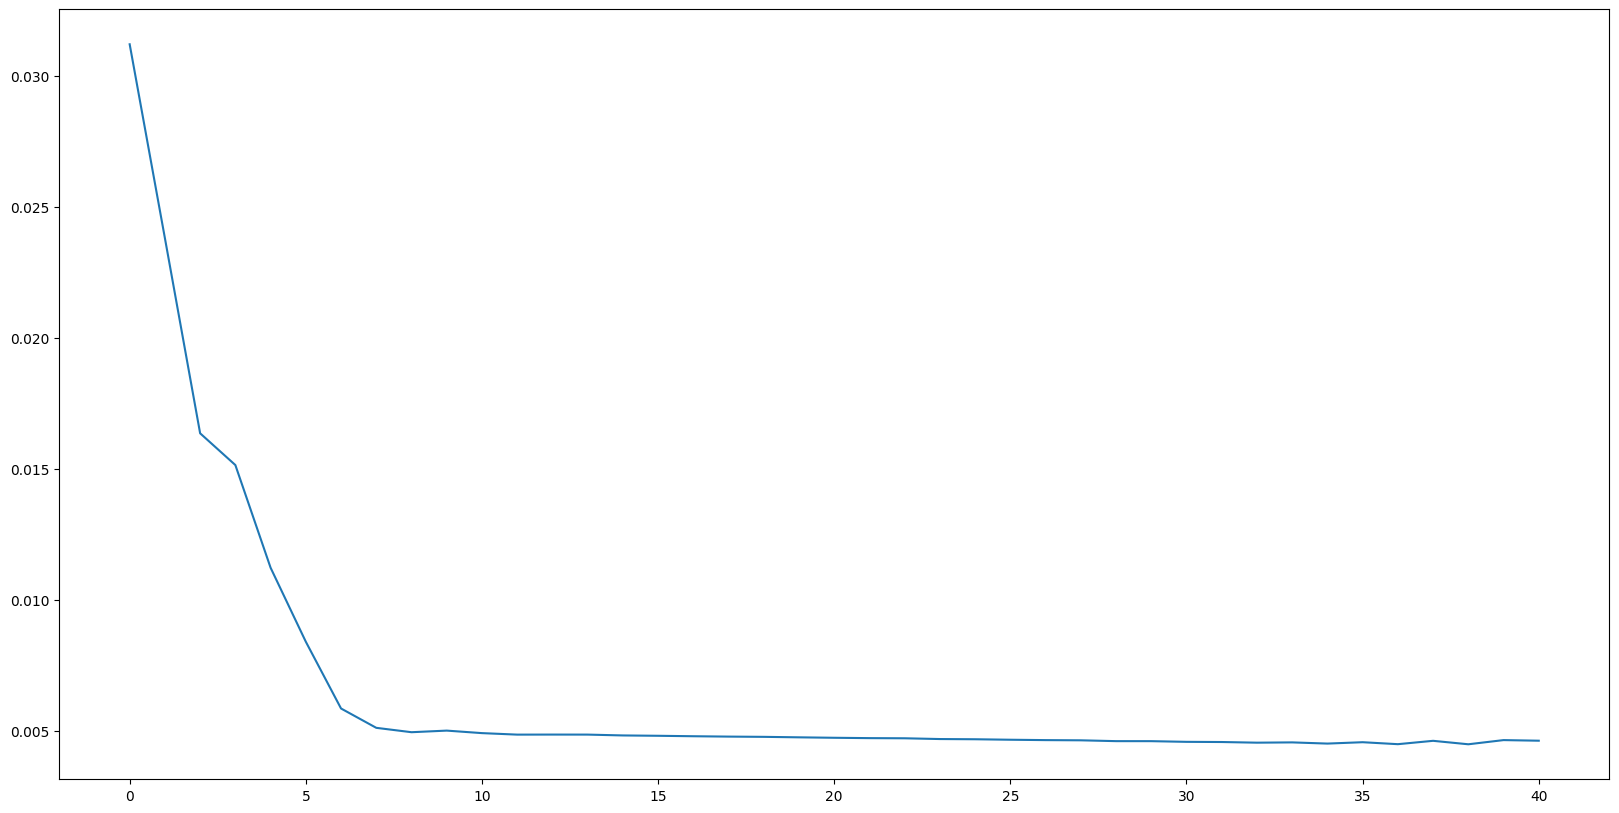

In [96]:
plt.figure(figsize = (20, 10))
plt.plot(loss_list)
plt.show()

## Model Save and Load

In [97]:
PATH = "../../model/BiRNN_many_to_one.pth"
torch.save(model.state_dict(), PATH)

In [98]:
PATH = "../../model/BiRNN_many_to_one.pth"
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers,
           dropout = 0.3, 
           device = device).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

RNN(
  (rnn): RNN(3, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=1920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## Visualize and Compare predicted values with actual values

In [100]:
train_predict = model(x_ss)
predicted = train_predict.cpu().data.numpy()
label_y = y_ms.cpu().data.numpy()

predicted = predicted.reshape(1103, 1)
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize = (10, 6))
plt.axvline(x = 800, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

ValueError: Found array with dim 3. None expected <= 2.

## Calculate MAE, RMSE, MAPE

In [90]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))
def RMSE(true, pred):
    return np.mean((true-pred)**2)**(1/2)
def MAPE(true, pred):
    return 100 * np.mean(np.abs((true-pred)/true))

print('MAE SCORE : ', MAE(predicted, label_y))
print('RMSE SCORE : ', RMSE(predicted, label_y))
print('MAPE SCORE : ', MAPE(predicted, label_y))

MAE SCORE :  6140.961
RMSE SCORE :  8254.853602578303
MAPE SCORE :  76.82923674583435


# Predict

## Predict more values

In [37]:
pre_ori_df = torch.zeros(1, 60, 3)
pre_ori_df[0] = x[-1]
val7 = [10000, 12000, 18000, 30000, 38000, 60000, 120000]
pre7 = []

for i in range(len(val7)):
    pre_ori_df[0][:-1] = pre_ori_df[0][1:].clone()
    pre_ori_df[0][-1][0] = val7[i]
    pre_ori_df[0][-1][1] = pre_ori_df[0][-1][0] - pre_ori_df[0][-2][0]
    pre_ori_df[0][-1][2] = pre_ori_df[0][-1][1] - pre_ori_df[0][-2][1]
    
    pre_ms_df = pre_ori_df.reshape(-1, 1)
    pre_ms_df = ms.transform(pre_ms_df).reshape(1, 60, 3)
    
    pre_ms_value = model(torch.FloatTensor(pre_ms_df).to(device))
    pre_ms_value = pre_ms_value.cpu().detach().numpy().reshape(-1, 1)
    pre_ori_value = ms.inverse_transform(pre_ms_value)

    pre7.append(pre_ori_value[0][0])

print(pre7) 

pre7 = np.array(pre7).reshape(-1, 1)
predicted_final = np.vstack((predicted, pre7))
label_y_final = np.vstack((label_y, np.array(val7).reshape(-1, 1)))

[10573.236, 10696.29, 10817.198, 11053.141, 11375.114, 11856.014, 12687.97]


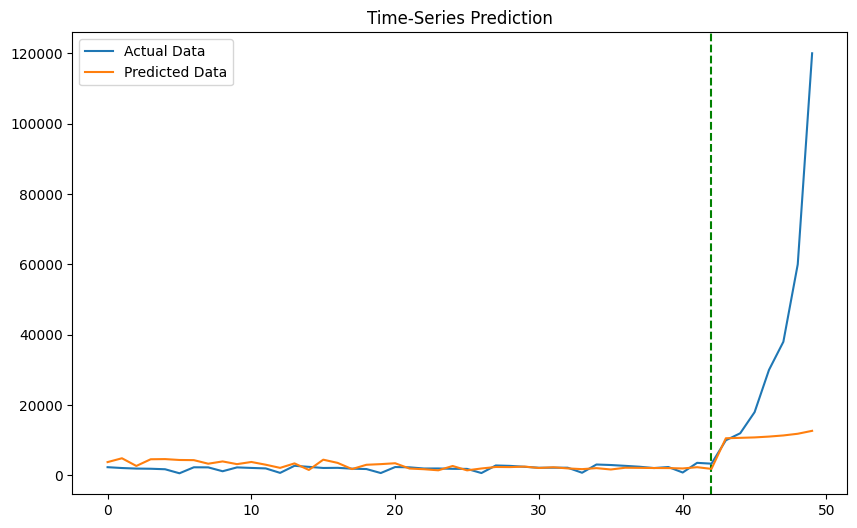

In [38]:
plt.figure(figsize = (10, 6)) 
plt.axvline(x = 42, c = 'g', linestyle = '--')

plt.plot(label_y_final[-50:], label = 'Actual Data')
plt.plot(predicted_final[-50:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

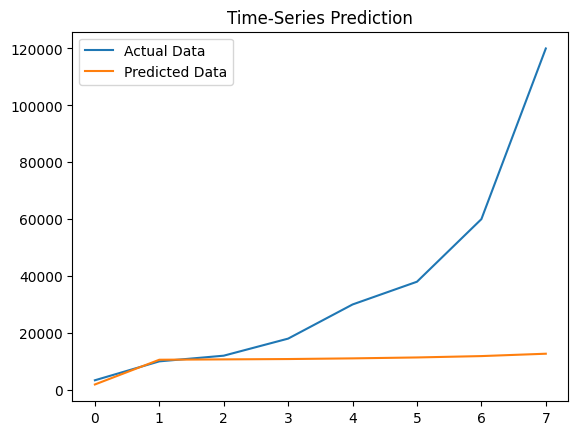

In [39]:
plt.plot(label_y_final[-8:], label = 'Actual Data')
plt.plot(predicted_final[-8:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()